In [1]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

# SERVOMECANISMO COM INTEGRADOR

In [2]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=4):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

In [3]:
s = ctl.TransferFunction.s

G     = 0.0253/(s - 5.0044)
G_bkp = G
G

TransferFunction(array([0.0253]), array([ 1.    , -5.0044]))

polos:  (5.004+0j)
zeros: 


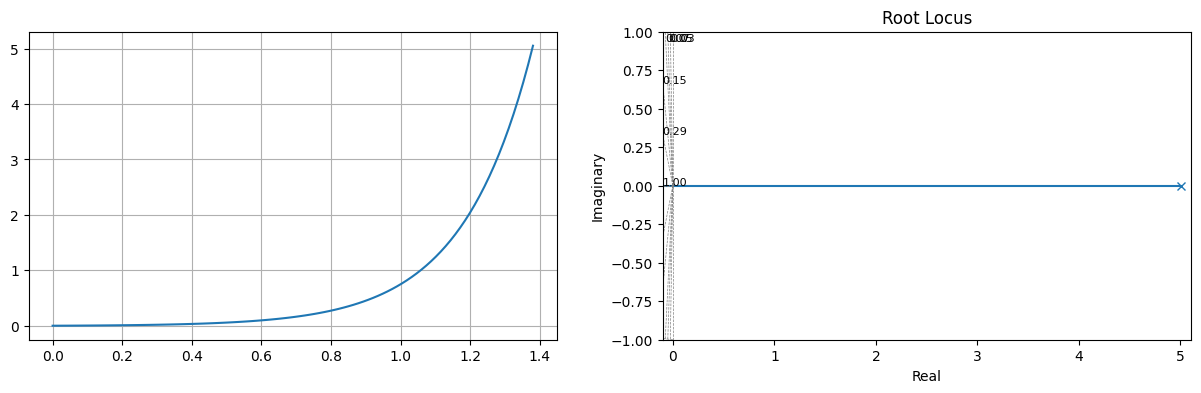

In [4]:
poles = ctl.poles(G)
zeros = ctl.zeros(G)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G)
plt.show()

# REQUISITOS DE CONTROLE

(0.5911550337988976, 1.3532829025560638, -0.8 + 1.092*I)

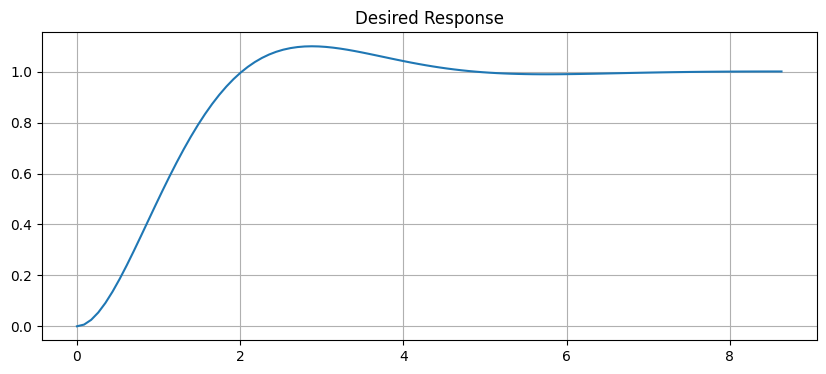

In [5]:
Ts = 5.0
UP = 0.1

zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
Wn = 4/(zeta*Ts)

s_d = -zeta*Wn + Wn*np.sqrt(1-zeta**2)*sp.I
s_d = roundSympyFunction(s_d, 3)
G_desired = Wn**2/(s**2 + 2*zeta*Wn*s + Wn**2)

time, response = ctl.step_response(G_desired)
plt.figure(figsize=(10, 4))
plt.plot(time, response)
plt.title('Desired Response'), plt.grid()
(zeta, Wn, s_d)

In [6]:
s1 = -zeta*Wn + Wn*np.sqrt(1-zeta**2)*1j
s2 = -zeta*Wn - Wn*np.sqrt(1-zeta**2)*1j
s3 = -5                                    # 2 a 5 vezes mais distante dos polos dominantes (parte real)
s4 = -5                                    # 2 a 5 vezes mais distante dos polos dominantes (parte real)
s5 = -5                                    # 2 a 5 vezes mais distante dos polos dominantes (parte real)

p = [np.round(val, 2) for val in [s1, s2]]
p

[(-0.8+1.09j), (-0.8-1.09j)]

# ESPAÇO DE ESTADOS
- Forma padrão (computacional)

In [7]:
matrix = ctl.tf2ss(G)
A, B, C, D = matrix.A, matrix.B, matrix.C, matrix.D

display(sp.Matrix(A))
display(sp.Matrix(B))
display(sp.Matrix(C))
display(sp.Matrix(D))

Matrix([[5.0044]])

Matrix([[1.0]])

Matrix([[0.0253]])

Matrix([[0]])

- Forma variáveis de fase (convencional)

In [8]:
def getVariaveisFase(G):
    matrix = ctl.tf2ss(G)
    A, B, C, D = matrix.A, matrix.B, matrix.C, matrix.D
    
    n = A.shape[0]

    # Cria uma matriz P com elementos 1 na diagonal secundária
    P = np.fliplr(np.eye(n))

    # Calcula a inversa da matriz P
    P_inv = np.linalg.inv(P)

    # Realiza as operações para obter a forma de variáveis de fase
    A = P_inv @ A @ P
    B = P_inv @ B
    C = C @ P
    D = D
    
    return A, B, C, D

A, B, C, D = getVariaveisFase(G)
A, B, C, D = sp.Matrix(A), sp.Matrix(B), sp.Matrix(C), sp.Matrix(D)

display(A)
display(B)
display(C)
display(D)

Matrix([[5.0044]])

Matrix([[1.0]])

Matrix([[0.0253]])

Matrix([[0]])

In [9]:
n = sp.shape(A)[0]
n

1

# CONTROLADOR

In [10]:
Ahat = sp.Matrix([
    [A,  sp.zeros(n, 1)],
    [-C, sp.zeros(1, 1)]
])

Bhat = sp.Matrix([
    [B],
    [sp.zeros(1, 1)]
])

Chat = sp.Matrix([
    [C, sp.zeros(1, 1)]
])

Dhat = D

display(Ahat)
display(Bhat)
display(Chat)
display(Dhat)

Matrix([
[ 5.0044, 0],
[-0.0253, 0]])

Matrix([
[1.0],
[  0]])

Matrix([[0.0253, 0]])

Matrix([[0]])

In [11]:
K = ctl.acker(Ahat, Bhat, p)
#K = ctl.place(A, B, p)

Ki = -1 * K[0][-1]
K  = np.array([K[0][:-1]]) # desconsiderando o últomo elemento que é o Ki

print(Ki)
sp.Matrix(K)

72.25691699604744


Matrix([[6.6044]])

In [12]:
s = sp.symbols('s')
I = sp.eye(n+1) 
K = sp.Matrix(K)

In [13]:
A_new = sp.Matrix([
    [A - B*K, B*Ki],
    [-C, sp.zeros(1, 1)]
])

B_new = sp.Matrix([
    [sp.zeros(n, 1)],
    [1]
])

C_new = sp.Matrix([
    [C, sp.zeros(1, 1)]
])

D_new = D

display(A_new)
display(B_new)
display(C_new)
display(D_new)

Matrix([
[   -1.6, 72.2569169960474],
[-0.0253,                0]])

Matrix([
[0],
[1]])

Matrix([[0.0253, 0]])

Matrix([[0]])

- Obtendo toda a função de transferência: $T_F = \frac{Y(s)}{U(s)} = C(sI - A)^{-1}B + D$

In [14]:
T = C_new * (s*I - A_new).inv() * B_new + D_new
T = T[0]
T

0.04625093/(0.0253*s**2 + 0.04048*s + 0.04625093)

In [15]:
G = sympyFunction(G)
G

0.0253/(1.0*s - 5.0044)

- O controlador C é obtido usando a relação $T(s) = \frac{G(s)C(s)}{1 + C(s)C(s)}$

In [16]:
C = T/(G*(1 - T))
C = C.expand().simplify().factor().cancel()
C = roundSympyFunction(C)
C

(16.4666*s**3 - 56.0588*s**2 - 101.7459*s - 150.6451)/(0.2279*s**4 + 0.7292*s**3 + 1.0*s**2 + 0.6666*s)

# RESPOSTA CONTROLADA

In [17]:
s = ctl.TransferFunction.s
C = eval(str(C))
G = G_bkp

In [18]:
G_ma = G*C
G_ma

TransferFunction(array([ 0.41660498, -1.41828764, -2.57417127, -3.81132103]), array([ 0.2279    , -0.41130276, -2.64920848, -4.3378    , -3.33593304,
        0.        ]))

In [19]:
G_feedback = ctl.feedback(G_ma, 1)
G_feedback

TransferFunction(array([ 0.41660498, -1.41828764, -2.57417127, -3.81132103]), array([ 0.2279    , -0.41130276, -2.2326035 , -5.75608764, -5.91010431,
       -3.81132103]))

- Como todos os polos do sistema em malha fechada estão no semiplano esquerdo, o sistema é estável

polos:  (5.004+0j) (-0.799+1.102j) (-0.799-1.102j) (-0.801+1.078j) (-0.801-1.078j)
zeros:  (5.004+0j) (-0.8+1.09j) (-0.8-1.09j)


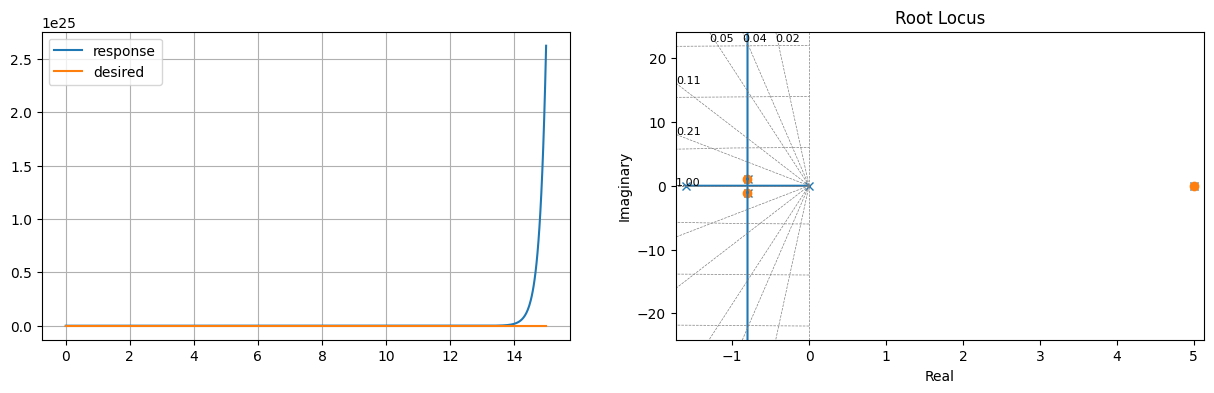

In [20]:
poles = ctl.poles(G_feedback)
zeros = ctl.zeros(G_feedback)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

tData = np.linspace(0, 3*Ts, 1000)
time, response = ctl.step_response(G_feedback, T=tData)
time, desired  = ctl.step_response(G_desired, T=tData)

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(time, response, label='response')
plt.plot(time, desired, label='desired')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
ctl.root_locus(G_ma)
plt.show()

In [21]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, setpoint=1)

overshoot:  0.0
valor de pico:  2.6232691951541136e+25
tempo de pico:  15.0
tempo de assentamento:  None
valor final:  2.6232691951541136e+25
erro:  2.6232691951541136e+25


# APLICANDO VÁRIOS STEPS

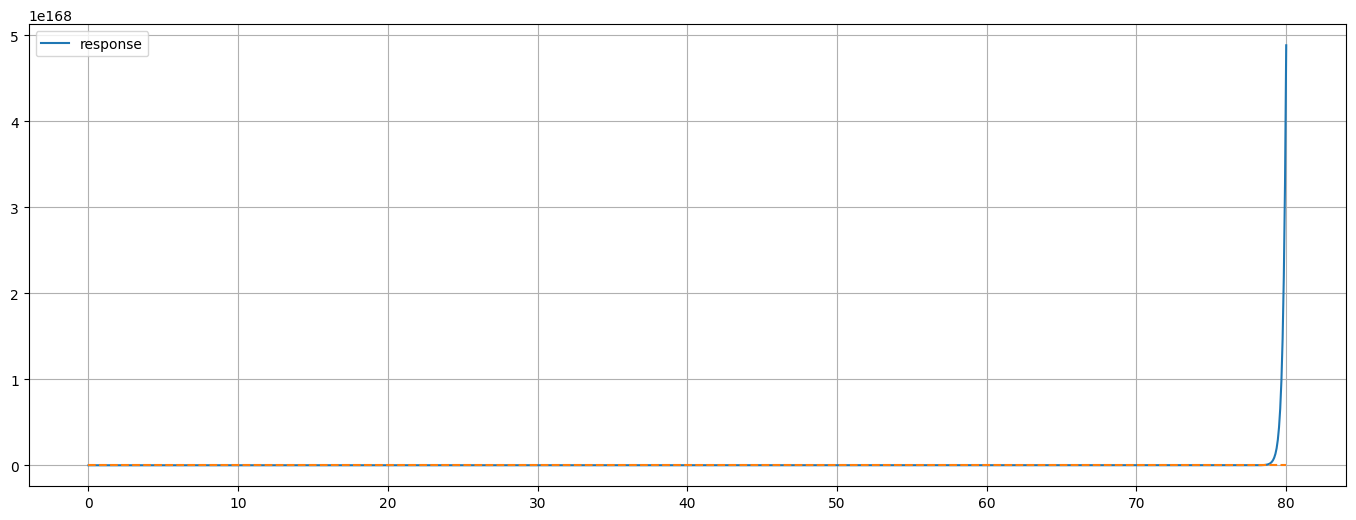

In [22]:
def makeSteps(stepList, length):
    stepSize = length // len(stepList)
    array = []

    for step in stepList:
        array = array + list(step * np.ones(stepSize))

    sizeLeft = len(array) - length

    if sizeLeft > 0:
        array = array + list(stepList[-1] * np.ones(sizeLeft))

    return array


tData = np.linspace(0, 80, 1000)
uData = makeSteps([100, 20, 80, 45, 30], len(tData))

plt.figure(figsize=(17, 6))
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)
plt.plot(time, response, label='response')
plt.plot(time, uData, '--')
plt.legend()
plt.grid()